In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from IPython.display import Image, display
from PIL import Image
import cv2
import matplotlib.pyplot as plt

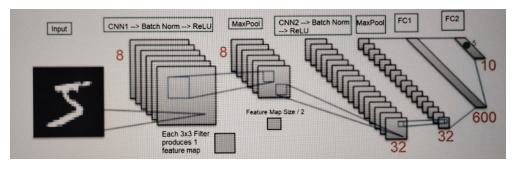

In [2]:
image = Image.open('E:\\University\\Інше\\IV Amazinum Data Science Camp\\Lecture 29\\model.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [3]:
# Specify the Mean and standard deviation of all the pixels in the MNIST dataset. They are precomputed 
mean_gray = 0.1307
stddev_gray = 0.3081

#Transform the images to tensors
#Normalize a tensor image with mean and standard deviation. Given mean: (M1,...,Mn) and std: (S1,..,Sn) 
#for n channels, this transform will normalize each channel of the input torch.Tensor
#i.e. input[channel] = (input[channel] - mean[channel]) / std[channel]

transforms_ori = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean_gray,), (stddev_gray,))])

transforms_photo = transforms.Compose([transforms.Resize((28,28)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((mean_gray,), (stddev_gray,))])

#Load our dataset
train_dataset = datasets.MNIST(root = './data', 
                            train = True, 
                            transform = transforms_ori,
                            download = True)

test_dataset = datasets.MNIST(root = './data', 
                            train = False, 
                            transform = transforms_ori)

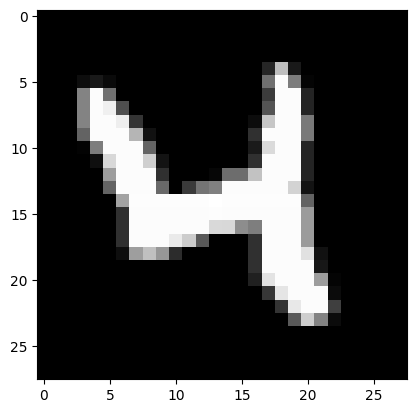

In [4]:
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28, 28), cmap='gray')

In [5]:
train_dataset[20][1]

4

In [6]:
batch_size = 100
epochs = 10

train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True)

test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                         shuffle = False)


In [7]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_load)))
print('There are {} batches in the testloader'.format(len(test_load)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


* in_channels=1 because the photo is black and white if it was colored, then in_channels = 3
* out_channels = 8 - how many filters we need
* kernel_size = 3 - it's filter size (3*3)
* stride - it's step our filter

    same padding -> input_size == output_size
    
* $ \text{same padding} = \frac{{\text{filter\_size} - 1}}{2} $

* $ \text{output\_size} = \left( \frac{{\text{input\_size} - \text{filter\_size} + 2 \times \text{padding}}}{\text{stride}} \right) + 1 $

* $ \text{output Size after pooling} = \frac{{\text{input\_size}}}{{\text{pooling\_size}}} $




In [8]:
#Create the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        #Same Padding = [(filter size - 1) / 2] (Same Padding--> input size = output size)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3,stride=1, padding=1)
        #The output size of each of the 8 feature maps is 
        #[(input_size - filter_size + 2(padding) / stride) +1] --> [(28-3+2(1)/1)+1] = 28 (padding type is same)
        #Batch normalization
        self.batchnorm1 = nn.BatchNorm2d(8)
        #RELU
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is now 28/2 = 14
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        #Output size of each of the 32 feature maps remains 14
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        #After max pooling, the output of each feature map is 14/2 = 7
        #Flatten the feature maps. You have 32 feature maps, each of them is of size 7x7 --> 32*7*7 = 1568
        self.fc1 = nn.Linear(in_features=1568, out_features=600)
        self.droput = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=600, out_features=10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Now we have to flatten the output. This is where we apply the feed forward neural network as learned before! 
        #It will take the shape (batch_size, 1568) = (100, 1568)
        out = out.view(-1,1568)
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        return out

In [9]:
CUDA = torch.cuda.is_available()
CUDA

True

In [10]:
model = CNN()

CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
    
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.03)

    correct -> how many correct predictions do we have
    
    iter_loss -> loss for one iteration

In [11]:
#Training the CNN
num_epochs = 10

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()               # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()            # Accumulate the loss
        loss.backward()                     # Backpropagation 
        optimizer.step()                    # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                        # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        loss += loss.item()
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(loss /iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1],test_loss[-1], test_accuracy[-1]))

Epoch 1/10, Training Loss: 0.273, Training Accuracy: 92.248, Testing Loss: 0.002, Testing Acc: 97.560
Epoch 2/10, Training Loss: 0.090, Training Accuracy: 97.377, Testing Loss: 0.001, Testing Acc: 98.330
Epoch 3/10, Training Loss: 0.067, Training Accuracy: 97.990, Testing Loss: 0.001, Testing Acc: 98.490
Epoch 4/10, Training Loss: 0.056, Training Accuracy: 98.328, Testing Loss: 0.000, Testing Acc: 98.560
Epoch 5/10, Training Loss: 0.047, Training Accuracy: 98.603, Testing Loss: 0.001, Testing Acc: 98.640
Epoch 6/10, Training Loss: 0.041, Training Accuracy: 98.710, Testing Loss: 0.000, Testing Acc: 98.980
Epoch 7/10, Training Loss: 0.038, Training Accuracy: 98.855, Testing Loss: 0.000, Testing Acc: 98.980
Epoch 8/10, Training Loss: 0.034, Training Accuracy: 98.937, Testing Loss: 0.000, Testing Acc: 99.160
Epoch 9/10, Training Loss: 0.030, Training Accuracy: 99.123, Testing Loss: 0.000, Testing Acc: 99.070
Epoch 10/10, Training Loss: 0.028, Training Accuracy: 99.153, Testing Loss: 0.000,

In [12]:
#Predict your own image
def predict(img_name,model):
    image = cv2.imread(img_name,0)   #Read the image
    ret, thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)   #Threshold the image
    img = 255-thresholded           #Apply image negative
    cv2.imshow('Original',img)      #Display the processed image
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    img = Image.fromarray(img)      #Convert the image to an array
    img = transforms_photo(img)     #Apply the transformations 
    img = img.view(1,1,28,28)       #Add batch size 
    img = Variable(img)             #Wrap the tensor to a variable
    
    label = torch.tensor(7)
    
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()
        img = img.cuda()

    output = model(img)
    print(output)
    print(output.data)
    _, predicted = torch.max(output,1)

    print("Prediction is: ", predicted.item())
    print("Actual is: ", label.item())
    return  predicted.item()

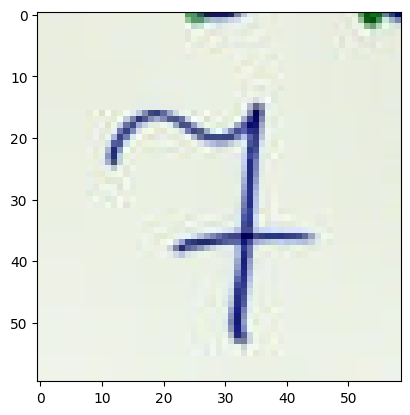

tensor([[-2.2736,  1.7320,  1.4259,  0.6086,  0.0092, -0.2450, -3.0762,  4.3840,
         -1.6753,  0.2311]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-2.2736,  1.7320,  1.4259,  0.6086,  0.0092, -0.2450, -3.0762,  4.3840,
         -1.6753,  0.2311]], device='cuda:0')
Prediction is:  7
Actual is:  7
The Predicted Label is 7


In [13]:
path = 'number_7.jpg'

image = Image.open(path)
plt.imshow(image)
plt.show()

pred = predict(path, model)
print("The Predicted Label is {}".format(pred))